In [4]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train','test'],
    shuffle_files = True,
    with_info = True,
)

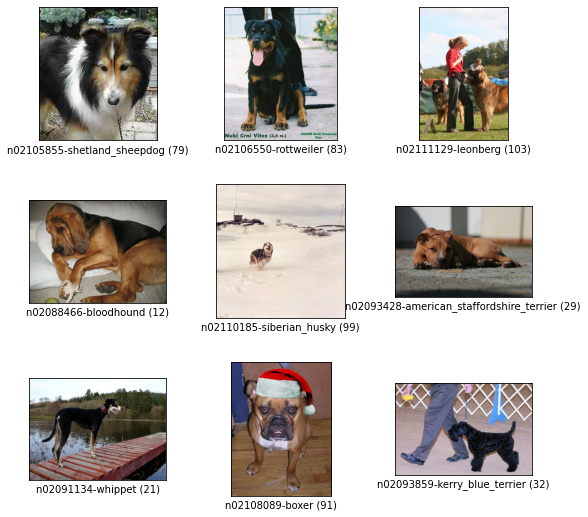

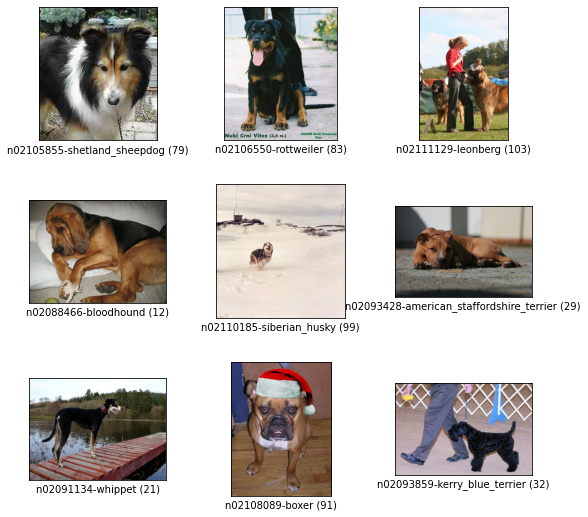

In [7]:
tfds.show_examples(ds_train,ds_info)

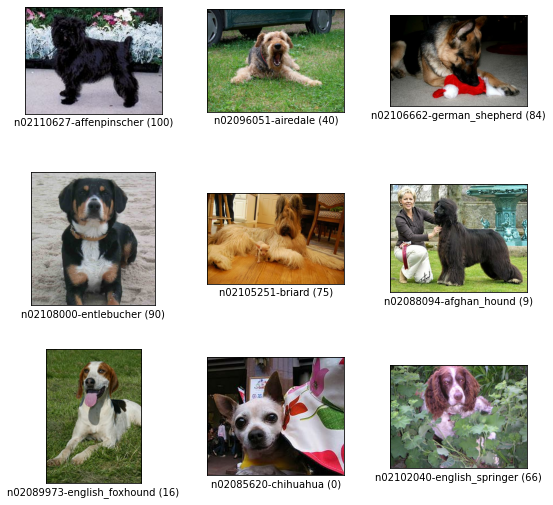

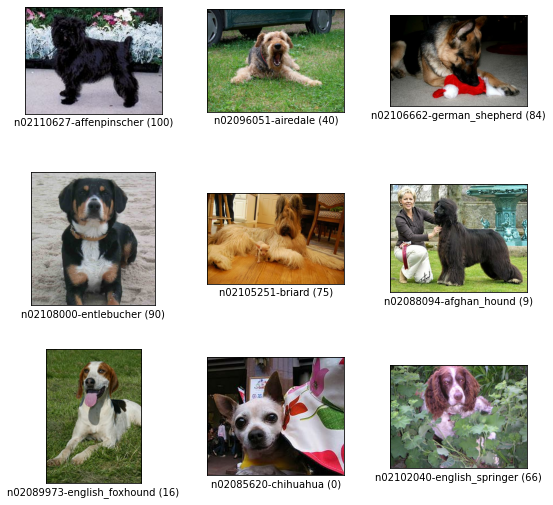

In [8]:
tfds.show_examples(ds_test,ds_info)

In [9]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [10]:
BATCH_SIZE = 16

In [11]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224,224,3),
        pooling = 'avg',
)
x = base_model.output
preds = keras.layers.Dense(num_classes,activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [12]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [13]:
def normallize_and_resize_img(input):
    image = tf.image.resize(input['image'],[224,224])
    input['image'] = tf.cast(image,tf.float32)/255.
    return input['image'], input['label']
    
def apply_normalize_on_dataset(ds, is_test=False,batch_size=16):
    ds = ds.map(
        normallize_and_resize_img,
        num_parallel_calls = 2
    )

    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [14]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

for input in ds_train_norm.take(1):
    image,label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [15]:
tf.random.set_seed(2021)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],

)

In [16]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=1,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

750/750 [==============================] - 384s 464ms/step - loss: 3.2118 - accuracy: 0.2745 - val_loss: 3.6358 - val_accuracy: 0.1778


In [17]:
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)

In [20]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split = ['train','test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_image(input):
    image = tf.image.resize(input['image'],[224,224])
    input['image'] = tf.cast(image,tf.float32)/255.
    return input['image'],input['label']

def apply_normalize_on_dataset(ds, is_test=False,batch_size=BATCH_SIZE):
    ds = ds.map(
        normallize_and_resize_img,
        num_parallel_calls = 2
    )

    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [21]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

40


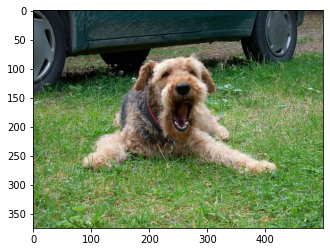

In [22]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [23]:
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)


In [24]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]

    img_tensor, class_idx = normalize_and_resize_image(item)

    cam_model = tf.keras.models.Model([model.inputs],[model.layers[-3].output , model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor,0))

    conv_outputs = conv_outputs[0,:,:,:]
    class_weights = model.layers[-1].get_weights()[0]

    cam_image = np.zeros(dtype=np.float32, shape = conv_outputs.shape[0:2])
    for i ,w in enumerate(class_weights[:,class_idx]):
        cam_image += w * conv_outputs[:,:,i]
    
    
    cam_image /= np.max(cam_image)
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image,(width,height))
    return cam_image

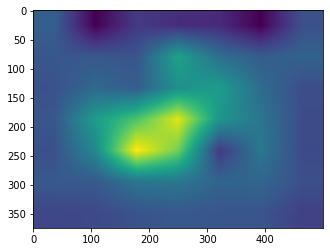

In [25]:
cam_image = generate_cam(cam_model,item)
plt.imshow(cam_image)
plt.show()

In [26]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

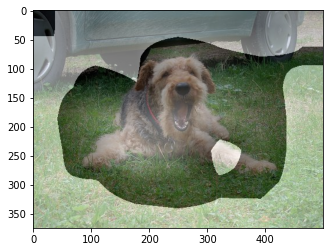

In [27]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

67


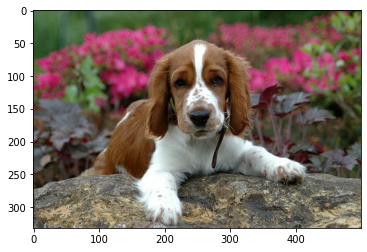

In [34]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [41]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_image(item)

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])

    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor,0))

        loss = pred[:,class_idx]
        output = conv_output[0]
        grad_val = tape.gradient(loss,conv_output)[0]

    weights = np.mean(grad_val,axis=(0,1))
    grad_cam_image = np.zeros(dtype=np.float32, shape= conv_output.shape[0:2])

    for k ,w in enumerate(weights):
        grad_cam_image += w * output[:,:,k]

    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image,(width,height))
    return grad_cam_image



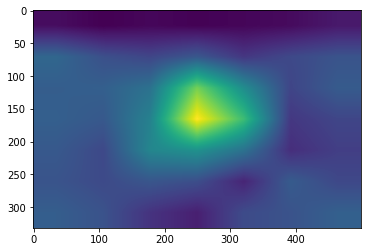

In [42]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out',item)
plt.imshow(grad_cam_image)
plt.show()


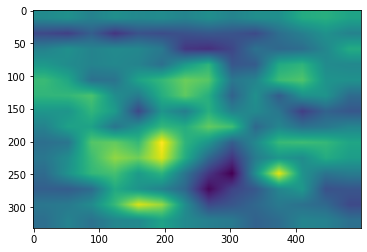

In [43]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out',item)
plt.imshow(grad_cam_image)
plt.show()

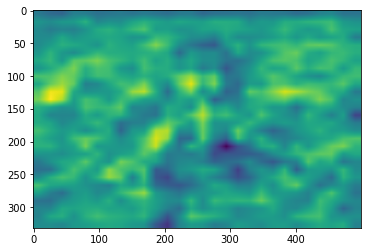

In [44]:
grad_cam_image = generate_grad_cam(cam_model,'conv3_block3_out',item)
plt.imshow(grad_cam_image)
plt.show()

80


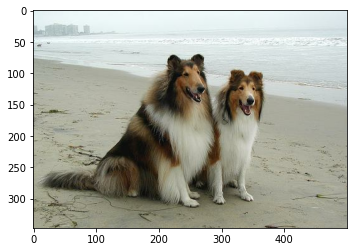

In [46]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

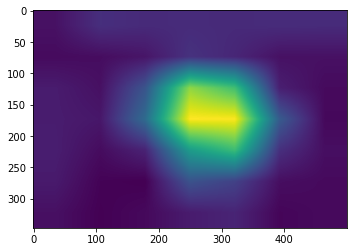

In [47]:
cam_image = generate_cam(cam_model,item)
plt.imshow(cam_image)
plt.show()

In [50]:
def get_bbox(cam_image,score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)

    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [60]:
rect = get_bbox(cam_image)
rect

array([[  0, 120],
       [ 59, 120],
       [ 59, 266],
       [  0, 266]])

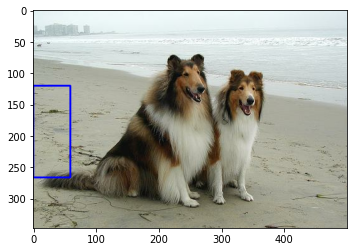

In [61]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)
plt.show()

In [62]:
def rect_to_minmax(rect,image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),
        rect[:,0].min()/float(image.shape[1]),
        rect[:,1].max()/float(image.shape[0]),
        rect[:,0].max()/float(image.shape[1])
    ]
    return bbox

In [63]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.345821325648415, 0.0, 0.7665706051873199, 0.118]

In [55]:
item['objects']['bbox']

array([[0.19596542, 0.02      , 0.9048991 , 0.578     ],
       [0.26224783, 0.584     , 0.89048994, 0.736     ]], dtype=float32)

In [56]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0],boxB[0])
    x_min = max(boxA[1],boxB[1])
    y_max = min(boxA[2],boxB[2])
    x_max = min(boxA[3],boxB[3])

    interArea = max(0 , x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2]-boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2]-boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [57]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.1020629405407756